## Part A

In this part, we used the CFRS approach to solve the VRP.

1. We extracted customer coordinates and demands from the excel file.
2. We converted the distances to realistic distances.(using euclidean distance)
3. We calculated the number of vehicles based on total demand and vehicle capacity (85 units).
4. We used the `CFRS` algorithm, which clusters customers based on capacity and applied Nearest Neighbor to construct routes.
5. We applied Two improvement algorithms to the CFRS routes:
   - **2-opt**
   - **Relocation**
6. Each solution was verified to:
   - Start and end at the depot (node 0)
   - Not exceed vehicle capacity
   - Visit all customers exactly once

  We also computed the **% improvement and times** over the base solution for both methods, and summarized them in a table and confirmed that all solutions are feasible.


In [15]:
!pip install ipynb

In [16]:
from scipy.cluster.vq import kmeans2, whiten
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

from ipynb.fs.full.TSPlib import two_opt
from ipynb.fs.full.TSPlib import relocate
from ipynb.fs.full.TSPlib import nearest_neighbor
from ipynb.fs.full.VRPlib import CFRS,RFCS


In [17]:

# Load Excel data
file_path = "Spring25Project_Data.xlsx"
df_demands = pd.read_excel(file_path, sheet_name='demands')
df_coordinates = pd.read_excel(file_path, sheet_name='coordinates')
# Extract coordinates as (x, y) pairs
coordinates = df_coordinates[['x-coordinate', 'y-coordinate']].values
# Extract demand values as a NumPy array
demands = df_demands['Demand'].values


In [18]:
df_coordinates

,Node ID,x-coordinate,y-coordinate
0,0,39,19
1,1,79,19
2,2,41,79
3,3,25,31
4,4,63,93
5,5,33,5
6,6,69,17
7,7,57,73
8,8,53,75
9,9,1,1


#**Euclidian Distance**

In [19]:
import math

lat = df_coordinates["y-coordinate"]
lon = df_coordinates["x-coordinate"]

# Calculate the average latitude
mean_lat = lat.mean()

# 1 degree of latitude is approximately 111320 meters
meters_per_deg_lat = 111320

# 1 degree of longitude is approximately 111320 * cos(average latitude) meters
meters_per_deg_lon = 111320 * math.cos(math.radians(mean_lat))

# Transform coordinates relative to a reference point
df_coordinates["x_m"] = (lon - lon.min()) * meters_per_deg_lon
df_coordinates["y_m"] = (lat - lat.min()) * meters_per_deg_lat

# Convert the transformed coordinates (in meters) to a numpy array
coords_m = df_coordinates[['x_m', 'y_m']].values

# Compute the distance matrix using numpy broadcasting
d = np.sqrt(((coords_m[:, None, :] - coords_m[None, :, :]) ** 2).sum(axis=2))



# **Constructing a VRP solution using cluster-first-route-second heuristic**

In [20]:

#demands are from the excel sheet,defined at the beginning
veh_cap = 85
total_demand = sum(demands)
k = math.ceil(total_demand/veh_cap) # number of vehicles available

print("Total demand:", total_demand)
print("Vehicle capacity:", veh_cap)
print("Estimated number of vehicles:", k)

Total demand: 526
Vehicle capacity: 85
Estimated number of vehicles: 7


#**CFRS with nearest neighbor consturction algorithm**





Added 38 to the tour!
Added 12 to the tour!
Added 37 to the tour!
Added 31 to the tour!
Added 14 to the tour!
Added 2 to the tour!
Added 19 to the tour!
Added 33 to the tour!
Added 25 to the tour!
Added 35 to the tour!
Added 7 to the tour!
Added 8 to the tour!
Added 10 to the tour!
Added 16 to the tour!
Added 4 to the tour!
Added 5 to the tour!
Added 29 to the tour!
Added 28 to the tour!
Added 9 to the tour!
Added 32 to the tour!
Added 18 to the tour!
Added 22 to the tour!
Added 34 to the tour!
Added 27 to the tour!
Added 11 to the tour!
Added 6 to the tour!
Added 1 to the tour!
Added 23 to the tour!
Added 21 to the tour!
Added 17 to the tour!
Added 36 to the tour!
Added 3 to the tour!
Added 13 to the tour!
Added 24 to the tour!
Added 15 to the tour!
Added 30 to the tour!
Added 20 to the tour!
Added 26 to the tour!


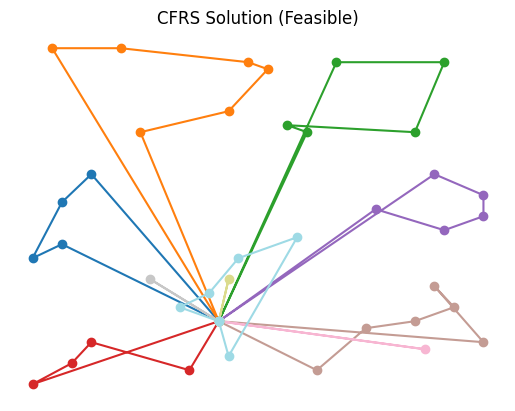


 Total runtime for CFRS: 0.4222 seconds


In [21]:
# Start timing
start_time = time.time()

vrp_solution1, total_length = CFRS(k, coordinates, d, plt, demands, veh_cap)
#customers are grouped basesd on capacity and the demand is checked cumulatively

# End timing
end_time = time.time()
runtime_CFRS = end_time - start_time
print(f"\n Total runtime for CFRS: {runtime_CFRS:.4f} seconds")

In [22]:
print("The VRP solution obtained by CFRS procedure:\n", vrp_solution1, "with a"
      " total length of", total_length)

The VRP solution obtained by CFRS procedure:
 [[0, 38, 12, 37, 31, 0], [0, 14, 2, 19, 33, 25, 35, 0], [0, 7, 8, 10, 16, 4, 0], [0, 5, 29, 28, 9, 0], [0, 32, 18, 22, 34, 27, 0], [0, 11, 6, 1, 23, 21, 17, 0], [0, 36, 0], [0, 3, 0], [0, 13, 0], [0, 24, 15, 30, 20, 26, 0]] with a total length of 111919861.75


# **Improvement with nearest neihbor + 2-opt algorithm**

Nearest nieghbor is aplied with the CFRS algorithm

# **Applying 2-opt algorithm to nearest neighbor solution**

In [23]:
#applying two-opt

# Start timing
start_time = time.time()


depot=0
improved_solution_2opt = []
improved_cost_2opt = 0

for route in vrp_solution1:
    if route[0] == 0 and route[-1] == 0:
        core = route[1:-1]
    else:
        core = route

    new_core, _ = two_opt(core, depot, d)
    new_route = [0] + new_core + [0]
    cost = sum(d[new_route[i]][new_route[i+1]] for i in range(len(new_route)-1))

    improved_solution_2opt.append(new_route)
    improved_cost_2opt += cost

print("\n Nearest Neighbor + 2-opt Results:")
for i, route in enumerate(improved_solution_2opt):
    print(f"Route {i+1}: {route}")
print("Total cost after 2-opt:", improved_cost_2opt)

# End timing
end_time = time.time()

runtime_CFRS_twoopt = end_time - start_time
print(f"\n Total runtime for CFRS + 2-opt Algorithm: {runtime_CFRS_twoopt:.4f} seconds")


Attempting to improve the tour [38, 12, 37, 31] with length 0
Cost difference due to swapping 12 and 37 is: 2512213.79

Attempting to improve the tour [14, 2, 19, 33, 25, 35] with length 0
Cost difference due to swapping 2 and 19 is: 2502112.71
Cost difference due to swapping 2 and 33 is: 1807126.06
Cost difference due to swapping 2 and 25 is: 3492331.14
Cost difference due to swapping 19 and 33 is: 472821.74
Cost difference due to swapping 19 and 25 is: 3599658.92
Cost difference due to swapping 33 and 25 is: 4150000.64

Attempting to improve the tour [7, 8, 10, 16, 4] with length 0
Cost difference due to swapping 8 and 10 is: 2291830.75
Cost difference due to swapping 8 and 16 is: 3168158.06
Cost difference due to swapping 10 and 16 is: 1985156.81

Attempting to improve the tour [5, 29, 28, 9] with length 0
Cost difference due to swapping 29 and 28 is: 812150.01

Attempting to improve the tour [32, 18, 22, 34, 27] with length 0
Cost difference due to swapping 18 and 22 is: 1069384.1

# **Applying Relocate algorithm to nearest neighbor solution**

In [24]:
#apply Relocate

# Start timing
start_time = time.time()


improved_solution_reloc = []
improved_cost_reloc = 0

for route in vrp_solution1:
    if route[0] == 0 and route[-1] == 0:
        core = route[1:-1]
    else:
        core = route

    improved_route, cost = relocate([0] + core + [0], depot=0, d=d)
    improved_solution_reloc.append(improved_route)
    improved_cost_reloc += cost

print("\n Nearest Neighbor + Relocation Results:")
for i, route in enumerate(improved_solution_reloc):
    print(f"Route {i+1}: {route}")
print("Total cost after Relocation:", improved_cost_reloc)

# End timing
end_time = time.time()

runtime_CFRS_relocate = end_time - start_time
print(f"\n Total runtime for CFRS + Relocate algorithm: {runtime_CFRS_relocate:.4f} seconds")



 Nearest Neighbor + Relocation Results:
Route 1: [0, 12, 38, 37, 31, 0]
Route 2: [0, 2, 19, 33, 25, 35, 14, 0]
Route 3: [0, 10, 16, 4, 8, 7, 0]
Route 4: [0, 29, 28, 9, 5, 0]
Route 5: [0, 18, 22, 34, 27, 32, 0]
Route 6: [0, 6, 1, 21, 23, 17, 11, 0]
Route 7: [0, 36, 0]
Route 8: [0, 3, 0]
Route 9: [0, 13, 0]
Route 10: [0, 26, 24, 15, 30, 20, 0]
Total cost after Relocation: 106243949.2488347

 Total runtime for CFRS + Relocate algorithm: 0.0062 seconds


In [25]:
# Improvement % Calculations
improve_2opt = ((total_length - improved_cost_2opt) / total_length) * 100
improve_reloc = ((total_length - improved_cost_reloc) / total_length) * 100

print("\n Improvement Summary:")
print(f"2-opt Improvement:       {improve_2opt:.2f}%")
print(f"Relocation Improvement:  {improve_reloc:.2f}%")



 Improvement Summary:
2-opt Improvement:       0.32%
Relocation Improvement:  5.07%


# Function,
# for checking the vehcile capacity,
# for visiting every vertex once,
# for starting and ending the tour at zero(depot)


In [26]:
def verify_solution(routes, demands, vehicle_capacity):
    all_customers = set()
    valid = True

    for idx, route in enumerate(routes):
        if route[0] != 0 or route[-1] != 0:
            print(f" Route {idx+1} does not start/end at depot.")
            valid = False

        # Remove depot entries to count only customers
        customers = [node for node in route if node != 0]

        demand = sum(demands[c] for c in customers)
        if demand > vehicle_capacity:
            print(f" Route {idx+1} exceeds capacity: {demand} > {vehicle_capacity}")
            valid = False

        all_customers.update(customers)

    expected_customers = set(range(1, len(demands)))  # excluding the depot, zero
    if all_customers != expected_customers:
        missing = expected_customers - all_customers
        extra = all_customers - expected_customers
        print(f" Customer mismatch. Missing: {missing}, Extra: {extra}")
        valid = False

    if valid:
        print(" All routes are valid!")
    return valid


print("\n Verifying Base CFRS + NN Solution:")
verify_solution(vrp_solution1, demands, veh_cap)

print("\n Verifying 2-opt Improved Solution:")
verify_solution(improved_solution_2opt, demands, veh_cap)

print("\n Verifying Relocation Improved Solution:")
verify_solution(improved_solution_reloc, demands, veh_cap)




 Verifying Base CFRS + NN Solution:
 All routes are valid!

 Verifying 2-opt Improved Solution:
 All routes are valid!

 Verifying Relocation Improved Solution:
 All routes are valid!


True

In [27]:
improve_2opt = ((total_length - improved_cost_2opt) / total_length) * 100
improve_reloc = ((total_length - improved_cost_reloc) / total_length) * 100

print("\n Improvement Summary:")
print(f"2-opt Improvement:       {improve_2opt:.2f}%")
print(f"Relocation Improvement:  {improve_reloc:.2f}%")



 Improvement Summary:
2-opt Improvement:       0.32%
Relocation Improvement:  5.07%


In [28]:
print("\n Final Comparison Table For Part A:")
print("{:<40} {:<10} {:<10} {:<12}".format("Combination", "Cost", "%improve", "Time (s)"))
print("_" * 70)
print("{:<40} {:<10.2f} {:<10.2f} {:<12.4f}".format("CFRS + Nearest Neighbor", total_length, 0.00, runtime_CFRS)) #formatting the decimals with -> :<10.2f
print("{:<40} {:<10.2f} {:<10.2f} {:<12.4f}".format("CFRS + NN + 2-opt", improved_cost_2opt, improve_2opt, runtime_CFRS + runtime_CFRS_twoopt))
print("{:<40} {:<10.2f} {:<10.2f} {:<12.4f}".format("CFRS + NN + Relocation", improved_cost_reloc, improve_reloc, runtime_CFRS + runtime_CFRS_relocate))



 Final Comparison Table For Part A:
Combination                              Cost       %improve   Time (s)    
______________________________________________________________________
CFRS + Nearest Neighbor                  111919861.75 0.00       0.4222      
CFRS + NN + 2-opt                        111566922.53 0.32       0.4559      
CFRS + NN + Relocation                   106243949.25 5.07       0.4284      
